# Import et préparation des données

# Sommaire :
 - <a href="#C1">Import des librairies et des données</a>
 - <a href="#C2">Analyse des types des colonnes</a>
 - <a href="#C3">Colonne date - tableau transactions: transformation en datetime</a>
 - <a href="#C4">Colonne date - tableau transactions : dates en 2022 et 2023</a>
 - <a href="#C41">Reconstitution du Chiffre d'affaires(prix 0_2245 manquant)</a>
 - <a href="#C6">Export des tableaux</a>
 
 # <a name="C1"> Import des librairies et des données</a>

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

import seaborn as sns

pd.options.display.max_columns = None # pour afficher toutes les colonnes
pd.options.display.max_rows = None # pour afficher toutes les lignes

customers = pd.read_csv('customers.csv')   
products = pd.read_csv('products.csv')
transactions = pd.read_csv('transactions.csv')

Visualisation des tableaux :

In [2]:
print(customers.head())
print('\n')
print(products.head())
print('\n')
print(transactions.head())

  client_id sex  birth
0    c_4410   f   1967
1    c_7839   f   1975
2    c_1699   f   1984
3    c_5961   f   1962
4    c_5320   m   1943


  id_prod  price  categ
0  0_1421  19.99      0
1  0_1368   5.13      0
2   0_731  17.99      0
3   1_587   4.99      1
4  0_1507   3.99      0


  id_prod                        date session_id client_id
0  0_1518  2022-05-20 13:21:29.043970   s_211425     c_103
1   1_251  2022-02-02 07:55:19.149409   s_158752    c_8534
2  0_1277  2022-06-18 15:44:33.155329   s_225667    c_6714
3   2_209  2021-06-24 04:19:29.835891    s_52962    c_6941
4  0_1509  2023-01-11 08:22:08.194479   s_325227    c_4232


Problème avec la colonne date tableau transactions : dates en 2022 et 2023.

Problème traité après l'analyse du type des colonnes.

# <a name="C2"> Analyse des types des colonnes</a>

In [3]:
print(customers.dtypes)
print('\n')
print(products.dtypes)
print('\n')
print(transactions.dtypes)

client_id    object
sex          object
birth         int64
dtype: object


id_prod     object
price      float64
categ        int64
dtype: object


id_prod       object
date          object
session_id    object
client_id     object
dtype: object


tableau customers
* client_id : clé alphanumérique => object attendu
* sex : string => object attendu
* birth : nombre entiers => int64 attendu

tableau products
* id_prod : clé alphanumérique => object attendu
* price : nombres décimaux => float64 attendu
* categ : nombres entiers => int64 attendu

tableau transactions
* id_prod : clé alphanumérique => object attendu
* date : A TRANSFORMER EN DATETIME
* session_id : clé alphanumérique => object attendu
* client_id : clé alphanumérique => object attendu

# <a name="C3">Colonne date - tableau transactions: transformation en datetime</a>

In [4]:
transactions['date'] = pd.to_datetime(transactions['date'], format='%Y-%m-%d %H:%M:%S.%f',errors='coerce')

vérification

In [5]:
transactions['date'].dtypes

dtype('<M8[ns]')

vérification validée

# <a name="C4">Colonne date - tableau transactions : dates en 2022 et 2023</a>

dates minimum et maximum :

In [6]:
print(transactions['date'].min())
print(transactions['date'].max())

2021-03-01 00:01:07.843138
2023-02-28 23:58:30.792755


Nous disposons des transactions du 01/03/2021 au 28/02/2023

création colonne annee_date :

In [7]:
transactions['annee_date'] = transactions['date'].dt.year

diagramme en bâtons représentant le nombre de ventes par année :

<AxesSubplot:>

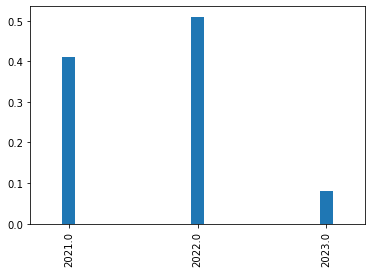

In [8]:
transactions['annee_date'].value_counts(normalize=True).sort_index().plot(kind='bar',width=0.1)

décompte du nombre de transactions par année :

In [9]:
vtes_par_annee = transactions['annee_date'].value_counts().sort_index()
vtes_par_annee

2021.0    278335
2022.0    346500
2023.0     54497
Name: annee_date, dtype: int64

#### Le plus probable semble être que les années sont décalées de 2 ans. Comme le site en ligne a ouvert "depuis 2 ans" (dixit mission OC) et que nous sommes début 2022, nous aurions les données pour 24 mois (hypothèse) :
- 2019 (à partir du mois de mars)
- 2020
- 2 premiers mois de 2021

Donc changement de toutes les dates en les faisant reculer de 2 ans :

In [10]:
transactions['date'] = transactions['date'].apply(lambda x: x.replace(year = x.year - 2))

Vérification

In [11]:
print(transactions.date.min())
print(transactions.date.max())

2019-03-01 00:01:07.843138
2021-02-28 23:58:30.792755


Vérification validée.

Suppression de la colonne 'annee_date' :

In [12]:
transactions.drop('annee_date',inplace=True,axis=1)

Vérification :

In [13]:
transactions.head()

,id_prod,date,session_id,client_id
0,0_1518,2020-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2020-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2020-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2019-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2021-01-11 08:22:08.194479,s_325227,c_4232


# <a name="C5">Fusion des tableaux</a>

## Fusion tableau transactions et tableau customers

In [14]:
df = transactions.merge(customers, how='outer', on='client_id',indicator=True)

Vérification de la fusion :

In [15]:
df._merge.value_counts()

both          679532
right_only        21
left_only          0
Name: _merge, dtype: int64

21 lignes du tableau customers n'ont pas été jointées.

Stockage et affichage de ces lignes :

In [16]:
clients_sans_transaction = df[df._merge == 'right_only']
clients_sans_transaction

,id_prod,date,session_id,client_id,sex,birth,_merge
679532,NaN,NaT,NaN,c_8253,f,2001,right_only
679533,NaN,NaT,NaN,c_3789,f,1997,right_only
679534,NaN,NaT,NaN,c_4406,f,1998,right_only
679535,NaN,NaT,NaN,c_2706,f,1967,right_only
679536,NaN,NaT,NaN,c_3443,m,1959,right_only
679537,NaN,NaT,NaN,c_4447,m,1956,right_only
679538,NaN,NaT,NaN,c_3017,f,1992,right_only
679539,NaN,NaT,NaN,c_4086,f,1992,right_only
679540,NaN,NaT,NaN,c_6930,m,2004,right_only
679541,NaN,NaT,NaN,c_4358,m,1999,right_only


#### Ces clients n'ont pas de transactions ; nous pouvons les éliminer des données : 

In [17]:
df.drop(clients_sans_transaction.index, inplace=True)

Vérification :

In [18]:
df._merge.value_counts()

both          679532
right_only         0
left_only          0
Name: _merge, dtype: int64

Suppression de la colonne _merge :

In [19]:
df.drop(columns=['_merge'],inplace=True)

Vérification :

In [20]:
df.head()

,id_prod,date,session_id,client_id,sex,birth
0,0_1518,2020-05-20 13:21:29.043970,s_211425,c_103,f,1986
1,0_1627,2020-06-18 05:55:31.816994,s_225494,c_103,f,1986
2,0_1104,2021-02-08 17:31:06.898425,s_338755,c_103,f,1986
3,0_1390,2019-04-20 06:18:39.939761,s_23078,c_103,f,1986
4,0_1547,2020-03-15 19:54:53.904123,s_179629,c_103,f,1986


## Fusion df-products

In [21]:
df = df.merge(products, how='outer', on='id_prod',indicator=True)

Vérification de la fusion :

In [22]:
df._merge.value_counts()

both          679311
left_only        221
right_only        21
Name: _merge, dtype: int64

221 transactions n'ont pas de produit associé et 21 produits n'ont pas de transactions.

### Transactions sans produit (left_only)

Stockage, affichage des lignes et nombre de lignes :

In [23]:
id_prod_transactions_ss_correspondance = df[df.price.isna()]
print('nombre de lignes :','\n',len(id_prod_transactions_ss_correspondance))
id_prod_transactions_ss_correspondance

nombre de lignes : 
 221


,id_prod,date,session_id,client_id,sex,birth,price,categ,_merge
311747,0_2245,2019-04-22 04:57:20.090378,s_23987,c_6714,f,1968.0,NaN,NaN,left_only
311748,0_2245,2019-06-05 17:04:43.982913,s_44481,c_6714,f,1968.0,NaN,NaN,left_only
311749,0_2245,2020-04-05 17:04:43.982913,s_189669,c_6714,f,1968.0,NaN,NaN,left_only
311750,0_2245,2020-05-05 17:04:43.982913,s_204093,c_6714,f,1968.0,NaN,NaN,left_only
311751,0_2245,2020-12-05 17:04:43.982913,s_307520,c_6714,f,1968.0,NaN,NaN,left_only
311752,0_2245,2020-07-22 04:57:20.090378,s_241918,c_6714,f,1968.0,NaN,NaN,left_only
311753,0_2245,2020-06-30 23:29:02.347672,s_231664,c_7790,f,1983.0,NaN,NaN,left_only
311754,0_2245,2019-03-30 23:29:02.347672,s_13738,c_7790,f,1983.0,NaN,NaN,left_only
311755,0_2245,2019-10-04 21:20:27.540982,s_100047,c_8138,f,1984.0,NaN,NaN,left_only
311756,0_2245,2020-01-09 09:23:31.000720,s_147220,c_4505,m,1976.0,NaN,NaN,left_only


Il semble n'y avoir que la clé id_prod = '0_2245'. Vérification :

In [24]:
print(len(df[(df.id_prod == '0_2245') & (df._merge == 'left_only')]))

221


Vérification validée.

Recherche d'une clé proche dans colonne id_prod tableau products.

Les clés id_prod sont constituées du N° de la catégorie de produit + un compteur ; donc 2 erreurs possibles qu'on pourrait retrouver :
- Erreur de catégorie ? Il faut trouver le même compteur (2245) accolé à 1 ou 2 au lieu de 0.
- 2 clés pour un même produit ? Il faut trouver 0_2245 + quelque chose ("0_2245-1", 0_2245-a", "0_22451", ...)

In [25]:
print(products[products['id_prod'].str.contains('2245')])

Empty DataFrame
Columns: [id_prod, price, categ]
Index: []


WARNING :
##### Pas de clé avec un compteur identique donc il faudra reconstituer le prix pour ces lignes.

### Produits sans transaction ('right_only')

In [26]:
id_prod_products_sans_correspondance = df[df._merge == 'right_only']

Ces produits n'ont pas fait l'objet d'une vente donc suppression :

In [27]:
df.drop(id_prod_products_sans_correspondance.index,inplace=True)

Vérification de la suppression :

In [28]:
df._merge.value_counts()

both          679311
left_only        221
right_only         0
Name: _merge, dtype: int64

Suppression de la colonne _merge

In [29]:
df.drop(columns=['_merge'],inplace=True)

Vérification de la suppression :

In [30]:
df.head()

,id_prod,date,session_id,client_id,sex,birth,price,categ
0,0_1518,2020-05-20 13:21:29.043970,s_211425,c_103,f,1986.0,4.18,0.0
1,0_1518,2019-07-20 13:21:29.043970,s_64849,c_103,f,1986.0,4.18,0.0
2,0_1518,2020-08-20 13:21:29.043970,s_255965,c_103,f,1986.0,4.18,0.0
3,0_1518,2019-05-09 11:52:55.100386,s_32104,c_6714,f,1968.0,4.18,0.0
4,0_1518,2020-05-30 01:17:07.487046,s_216118,c_6714,f,1968.0,4.18,0.0


## Taux de remplissage

In [31]:
print('Taux de remplissage par colonne :','\n',(1-df.isna().sum()/len(df))*100)
print('Nombre de lignes vides par colonne :','\n',df.isna().sum())

Taux de remplissage par colonne : 
 id_prod       100.000000
date           99.970568
session_id    100.000000
client_id     100.000000
sex           100.000000
birth         100.000000
price          99.967478
categ          99.967478
dtype: float64
Nombre de lignes vides par colonne : 
 id_prod         0
date          200
session_id      0
client_id       0
sex             0
birth           0
price         221
categ         221
dtype: int64


Il manque des données dans les colonnes date, prix et catégorie.

## Lignes sans date :

Stockage et affichage des lignes sans date et de leur nombre :

In [32]:
lignes_sans_date = df[df.date.isna()]
print('Nombre de lignes :','\n',len(lignes_sans_date))
print(lignes_sans_date)

Nombre de lignes : 
 200
       id_prod date session_id client_id sex   birth  price  categ
678715     T_0  NaT        s_0      ct_0   f  2001.0   -1.0    0.0
678716     T_0  NaT        s_0      ct_0   f  2001.0   -1.0    0.0
678717     T_0  NaT        s_0      ct_0   f  2001.0   -1.0    0.0
678718     T_0  NaT        s_0      ct_0   f  2001.0   -1.0    0.0
678719     T_0  NaT        s_0      ct_0   f  2001.0   -1.0    0.0
678720     T_0  NaT        s_0      ct_0   f  2001.0   -1.0    0.0
678721     T_0  NaT        s_0      ct_0   f  2001.0   -1.0    0.0
678722     T_0  NaT        s_0      ct_0   f  2001.0   -1.0    0.0
678723     T_0  NaT        s_0      ct_0   f  2001.0   -1.0    0.0
678724     T_0  NaT        s_0      ct_0   f  2001.0   -1.0    0.0
678725     T_0  NaT        s_0      ct_0   f  2001.0   -1.0    0.0
678726     T_0  NaT        s_0      ct_0   f  2001.0   -1.0    0.0
678727     T_0  NaT        s_0      ct_0   f  2001.0   -1.0    0.0
678728     T_0  NaT        s_0      c

Cela semble être des lignes de test car il y a toujours les mêmes valeurs. Vérification :

In [33]:
nom_des_colonnes = list(lignes_sans_date)
for i in nom_des_colonnes:
    print(lignes_sans_date[i].unique())

['T_0']
['NaT']
['s_0']
['ct_0' 'ct_1']
['f' 'm']
[2001.]
[-1.]
[0.]


Les seules valeurs qui ne sont pas uniques sont dans les colonnes client_id et sex : ct_0 quand c'est une femme et ct_1 quand c'est un homme.

Le prix est toujours à -1.

Il n'y a jamais de date.

##### Il s'agit de lignes de test à supprimer.

In [34]:
df.drop(lignes_sans_date.index,inplace=True)

Vérification :

In [35]:
print('Taux de remplissage par colonne :','\n',(1-df.isna().sum()/len(df))*100)

Taux de remplissage par colonne : 
 id_prod       100.000000
date          100.000000
session_id    100.000000
client_id     100.000000
sex           100.000000
birth         100.000000
price          99.967468
categ          99.967468
dtype: float64


Vérification validée.

## Lignes sans prix et sans catégorie

Affichage des lignes sans prix et sans catégorie ainsi que leur nombre :

In [36]:
print('Nombre de lignes :','\n',len(df[df.price.isna() & df.categ.isna()]))
df[df.price.isna() & df.categ.isna()]

Nombre de lignes : 
 221


,id_prod,date,session_id,client_id,sex,birth,price,categ
311747,0_2245,2019-04-22 04:57:20.090378,s_23987,c_6714,f,1968.0,NaN,NaN
311748,0_2245,2019-06-05 17:04:43.982913,s_44481,c_6714,f,1968.0,NaN,NaN
311749,0_2245,2020-04-05 17:04:43.982913,s_189669,c_6714,f,1968.0,NaN,NaN
311750,0_2245,2020-05-05 17:04:43.982913,s_204093,c_6714,f,1968.0,NaN,NaN
311751,0_2245,2020-12-05 17:04:43.982913,s_307520,c_6714,f,1968.0,NaN,NaN
311752,0_2245,2020-07-22 04:57:20.090378,s_241918,c_6714,f,1968.0,NaN,NaN
311753,0_2245,2020-06-30 23:29:02.347672,s_231664,c_7790,f,1983.0,NaN,NaN
311754,0_2245,2019-03-30 23:29:02.347672,s_13738,c_7790,f,1983.0,NaN,NaN
311755,0_2245,2019-10-04 21:20:27.540982,s_100047,c_8138,f,1984.0,NaN,NaN
311756,0_2245,2020-01-09 09:23:31.000720,s_147220,c_4505,m,1976.0,NaN,NaN


##### Il s'agit des lignes où id_prod= 0_2245 dans le tableau transactions sans correspondance dans le tableau products. Il faut les conserver car le prix et la catégorie peuvent être reconstitués.

# <a name="C41">Reconstitution du Chiffre d'affaires(prix 0_2245 manquant)</a>

l'id produit 0_2245 fait partie de la catégorie 0.

Nous allons donc calculer la moyenne et la médiane des produits achetés dans cette catégorie pour les clients ayant acheté le produit 0_2245.

Cela nous permettra de remplacer le prix manquant par la moyenne ou la médiane obtenue.

##### Stockage des id_prod 0_2245 et vérification :

In [37]:
id_prod_0_2245 = df[df['id_prod'] == '0_2245'] # Stockage dans un dataframe
print(id_prod_0_2245.head()) # Affichage des 5 1ères lignes
print('Nombre de lignes :',len(id_prod_0_2245)) # Nombre de lignes du dataframe

       id_prod                       date session_id client_id sex   birth  \
311747  0_2245 2019-04-22 04:57:20.090378    s_23987    c_6714   f  1968.0   
311748  0_2245 2019-06-05 17:04:43.982913    s_44481    c_6714   f  1968.0   
311749  0_2245 2020-04-05 17:04:43.982913   s_189669    c_6714   f  1968.0   
311750  0_2245 2020-05-05 17:04:43.982913   s_204093    c_6714   f  1968.0   
311751  0_2245 2020-12-05 17:04:43.982913   s_307520    c_6714   f  1968.0   

        price  categ  
311747    NaN    NaN  
311748    NaN    NaN  
311749    NaN    NaN  
311750    NaN    NaN  
311751    NaN    NaN  
Nombre de lignes : 221


221 lignes : c'est le nombre de lignes constaté lors de la constatation du problème.

##### Suppression de l'id_prod 0_2245 du dataframe d'origine et vérification :

In [38]:
df.drop(id_prod_0_2245.index, inplace=True) # Suppression
print(df[df['id_prod'] == '0_2245'])

Empty DataFrame
Columns: [id_prod, date, session_id, client_id, sex, birth, price, categ]
Index: []


##### Isolation des clients qui ont acheté le produit 0_2245 et vérification :

In [39]:
clients_0_2245 = id_prod_0_2245['client_id'].unique() #Stockage dans un objet de type numpy.array
clients_0_2245 = clients_0_2245.tolist() # Transformation de l'objet en list
print('Nombre de lignes :',len(clients_0_2245))
print('Type :',type(clients_0_2245))
print(clients_0_2245)

Nombre de lignes : 100
Type : <class 'list'>
['c_6714', 'c_7790', 'c_8138', 'c_4505', 'c_6268', 'c_4721', 'c_3454', 'c_966', 'c_3519', 'c_2288', 'c_1746', 'c_1595', 'c_7810', 'c_4964', 'c_1060', 'c_5352', 'c_8616', 'c_7849', 'c_3065', 'c_3953', 'c_580', 'c_8595', 'c_1025', 'c_4973', 'c_1403', 'c_1533', 'c_2688', 'c_2919', 'c_6205', 'c_1098', 'c_1514', 'c_8286', 'c_326', 'c_2142', 'c_7954', 'c_5869', 'c_6236', 'c_6990', 'c_4120', 'c_7287', 'c_2242', 'c_6952', 'c_2266', 'c_1657', 'c_8026', 'c_4167', 'c_4113', 'c_2189', 'c_4510', 'c_8096', 'c_4746', 'c_3496', 'c_4935', 'c_2039', 'c_8153', 'c_7102', 'c_5120', 'c_1876', 'c_5714', 'c_2028', 'c_4765', 'c_1391', 'c_4453', 'c_131', 'c_4854', 'c_5953', 'c_4283', 'c_662', 'c_6255', 'c_1579', 'c_2613', 'c_295', 'c_554', 'c_8060', 'c_4333', 'c_6713', 'c_1189', 'c_2006', 'c_277', 'c_2457', 'c_6189', 'c_5108', 'c_6356', 'c_1551', 'c_7808', 'c_5157', 'c_7759', 'c_8240', 'c_3468', 'c_7753', 'c_5056', 'c_4188', 'c_1811', 'c_8524', 'c_2504', 'c_553', 'c_

##### Calcul du prix moyen des articles achetés en catégorie 0 pour chacun des clients et vérification :

In [40]:
price_mean = []
df_cat_0 = df.loc[df['categ'] == 0]
for i in clients_0_2245:
    a = df_cat_0['price'][df_cat_0['client_id'] == i].mean()
    price_mean.append(a)
print('Nombre de lignes :', len(price_mean))
print('Type :',type(price_mean))
print(price_mean)

Nombre de lignes : 100
Type : <class 'list'>
[10.78240866290004, 10.648121546961335, 9.678781725888332, 11.20793548387097, 10.66814569536424, 10.010804020100508, 10.671001112347328, 10.160754716981138, 10.801818181818183, 11.113373493975907, 9.427272727272728, 11.988053691275175, 10.494752475247525, 10.7891095890411, 10.165210526315793, 10.510155642023324, 10.125389221556894, 11.457290322580645, 11.892399999999999, 10.587857142857148, 10.298521400778197, 10.148676470588235, 10.525663265306125, 10.776602870813388, 10.610000000000001, 9.438999999999998, 12.019047619047623, 9.944249999999997, 10.528448275862067, 9.375681818181825, 11.765370370370375, 10.912467532467534, 11.697878787878787, 10.268137254901967, 10.665666666666672, 8.958055555555557, 12.763108108108106, 10.525737704918043, 10.916415094339602, 11.094081632653063, 11.02240437158471, 9.928333333333336, 9.681617647058824, 9.474705882352946, 11.645618729096968, 10.691435185185183, 10.689230769230772, 9.307297297297302, 10.3076237

Vérification que tous les clients ont acheté au moins 1 produit de la catégorie 0 :

In [41]:
try:
  ndx = price_mean.index(0)
except:
  ndx = "Tous les clients ont acheté au moins une fois un produit de catégorie 1"

print (ndx)

Tous les clients ont acheté au moins une fois un produit de catégorie 1


## Calcul du prix médian des articles achetés pour chacun des clients et vérification :

In [42]:
price_median = []
for i in clients_0_2245:
    a = df_cat_0['price'][df_cat_0['client_id'] == i].median()
    price_median.append(a)
print('Nombre de lignes :', len(price_median))
print('Type :',type(price_median))
print(price_median)

Nombre de lignes : 100
Type : <class 'list'>
[10.36, 9.99, 8.99, 10.99, 9.99, 8.82, 9.99, 8.99, 10.715, 11.0, 8.96, 12.52, 9.32, 10.695, 8.99, 9.99, 8.99, 10.99, 11.66, 9.885, 9.66, 8.75, 9.31, 9.99, 9.28, 9.02, 9.99, 8.99, 10.99, 8.58, 11.73, 10.7, 10.0, 9.04, 10.18, 8.58, 12.879999999999999, 9.99, 10.99, 11.99, 11.38, 9.65, 8.11, 8.99, 11.99, 9.99, 10.7, 7.86, 8.99, 8.99, 10.99, 12.2, 12.99, 10.940000000000001, 8.465, 7.99, 8.61, 11.3, 9.825, 11.145, 9.93, 10.99, 11.53, 9.41, 8.99, 10.99, 9.93, 6.99, 10.99, 9.99, 9.43, 9.99, 10.99, 8.07, 12.03, 9.71, 11.004999999999999, 9.31, 13.254999999999999, 12.11, 10.99, 12.51, 7.515000000000001, 8.32, 11.645, 8.99, 8.99, 11.655000000000001, 8.99, 12.74, 8.99, 8.99, 9.99, 14.74, 10.99, 13.54, 8.58, 8.58, 13.965, 10.989999999999998]


##### Réunion des listes 'client_id' et 'price_mean' dans un dictionnaire.

In [43]:
# Création du dictionnaire regroupant client_id & moyenne des prix achetés
d = {'client_id':clients_0_2245,'price_mean':price_mean}
d

{'client_id': ['c_6714',
  'c_7790',
  'c_8138',
  'c_4505',
  'c_6268',
  'c_4721',
  'c_3454',
  'c_966',
  'c_3519',
  'c_2288',
  'c_1746',
  'c_1595',
  'c_7810',
  'c_4964',
  'c_1060',
  'c_5352',
  'c_8616',
  'c_7849',
  'c_3065',
  'c_3953',
  'c_580',
  'c_8595',
  'c_1025',
  'c_4973',
  'c_1403',
  'c_1533',
  'c_2688',
  'c_2919',
  'c_6205',
  'c_1098',
  'c_1514',
  'c_8286',
  'c_326',
  'c_2142',
  'c_7954',
  'c_5869',
  'c_6236',
  'c_6990',
  'c_4120',
  'c_7287',
  'c_2242',
  'c_6952',
  'c_2266',
  'c_1657',
  'c_8026',
  'c_4167',
  'c_4113',
  'c_2189',
  'c_4510',
  'c_8096',
  'c_4746',
  'c_3496',
  'c_4935',
  'c_2039',
  'c_8153',
  'c_7102',
  'c_5120',
  'c_1876',
  'c_5714',
  'c_2028',
  'c_4765',
  'c_1391',
  'c_4453',
  'c_131',
  'c_4854',
  'c_5953',
  'c_4283',
  'c_662',
  'c_6255',
  'c_1579',
  'c_2613',
  'c_295',
  'c_554',
  'c_8060',
  'c_4333',
  'c_6713',
  'c_1189',
  'c_2006',
  'c_277',
  'c_2457',
  'c_6189',
  'c_5108',
  'c_6356',

##### Réunion des listes 'client_id' et 'price_median' dans un dictionnaire.

In [44]:
# Création du dictionnaire regroupant client_id & moyenne des prix achetés
e = {'client_id':clients_0_2245,'price_median':price_median}
e

{'client_id': ['c_6714',
  'c_7790',
  'c_8138',
  'c_4505',
  'c_6268',
  'c_4721',
  'c_3454',
  'c_966',
  'c_3519',
  'c_2288',
  'c_1746',
  'c_1595',
  'c_7810',
  'c_4964',
  'c_1060',
  'c_5352',
  'c_8616',
  'c_7849',
  'c_3065',
  'c_3953',
  'c_580',
  'c_8595',
  'c_1025',
  'c_4973',
  'c_1403',
  'c_1533',
  'c_2688',
  'c_2919',
  'c_6205',
  'c_1098',
  'c_1514',
  'c_8286',
  'c_326',
  'c_2142',
  'c_7954',
  'c_5869',
  'c_6236',
  'c_6990',
  'c_4120',
  'c_7287',
  'c_2242',
  'c_6952',
  'c_2266',
  'c_1657',
  'c_8026',
  'c_4167',
  'c_4113',
  'c_2189',
  'c_4510',
  'c_8096',
  'c_4746',
  'c_3496',
  'c_4935',
  'c_2039',
  'c_8153',
  'c_7102',
  'c_5120',
  'c_1876',
  'c_5714',
  'c_2028',
  'c_4765',
  'c_1391',
  'c_4453',
  'c_131',
  'c_4854',
  'c_5953',
  'c_4283',
  'c_662',
  'c_6255',
  'c_1579',
  'c_2613',
  'c_295',
  'c_554',
  'c_8060',
  'c_4333',
  'c_6713',
  'c_1189',
  'c_2006',
  'c_277',
  'c_2457',
  'c_6189',
  'c_5108',
  'c_6356',

##### Transformation du dictionnaire d (moyenne) en dataframe :

In [45]:
clients_0_2245_mean = pd.DataFrame(d) # Transformation du dictionnaire en dataframe
print('Nombre de lignes :', len(clients_0_2245_mean))
print(clients_0_2245_mean.head())

Nombre de lignes : 100
  client_id  price_mean
0    c_6714   10.782409
1    c_7790   10.648122
2    c_8138    9.678782
3    c_4505   11.207935
4    c_6268   10.668146


##### Transformation du dictionnaire e (médiane) en dataframe :

In [46]:
clients_0_2245_median = pd.DataFrame(e) # Transformation du dictionnaire en dataframe
print('Nombre de lignes :', len(clients_0_2245_median))
print(clients_0_2245_median.head())

Nombre de lignes : 100
  client_id  price_median
0    c_6714         10.36
1    c_7790          9.99
2    c_8138          8.99
3    c_4505         10.99
4    c_6268          9.99


#### Création des dataframes id_prod_0_2245_mean et id_prod_0_2245_median

In [47]:
id_prod_0_2245_mean = id_prod_0_2245
id_prod_0_2245_median = id_prod_0_2245

##### Ajout des valeurs price et categ au dataframe id_prod_0_2245_mean :

In [48]:
for index, row in id_prod_0_2245_mean.iterrows():
        for index_1, row_1 in clients_0_2245_mean.iterrows():
            if row['client_id'] == row_1['client_id']:
                id_prod_0_2245_mean.at[index, 'price'] = row_1['price_mean']
print('nombre de lignes : ',len(id_prod_0_2245_mean))
print(id_prod_0_2245_mean[0:20])

nombre de lignes :  221
       id_prod                       date session_id client_id sex   birth  \
311747  0_2245 2019-04-22 04:57:20.090378    s_23987    c_6714   f  1968.0   
311748  0_2245 2019-06-05 17:04:43.982913    s_44481    c_6714   f  1968.0   
311749  0_2245 2020-04-05 17:04:43.982913   s_189669    c_6714   f  1968.0   
311750  0_2245 2020-05-05 17:04:43.982913   s_204093    c_6714   f  1968.0   
311751  0_2245 2020-12-05 17:04:43.982913   s_307520    c_6714   f  1968.0   
311752  0_2245 2020-07-22 04:57:20.090378   s_241918    c_6714   f  1968.0   
311753  0_2245 2020-06-30 23:29:02.347672   s_231664    c_7790   f  1983.0   
311754  0_2245 2019-03-30 23:29:02.347672    s_13738    c_7790   f  1983.0   
311755  0_2245 2019-10-04 21:20:27.540982   s_100047    c_8138   f  1984.0   
311756  0_2245 2020-01-09 09:23:31.000720   s_147220    c_4505   m  1976.0   
311757  0_2245 2020-11-09 09:23:31.000720   s_295013    c_4505   m  1976.0   
311758  0_2245 2021-01-21 18:39:25.64923

##### Vérification du résultat obtenu

Elaboration d'une fonction permettant de vérifier les moyennes renseignées sur id_prod 0_2245_mean pour un client et les moyennes de prix renseignées sur le dataframe de base.

Exécution de cette fonction sur certains clients, pris au hasard, qui ont acheté id_prod 0_2245.

In [49]:
def mean_verif(client_id) :
    print(df_cat_0['price'][df_cat_0['client_id'] == client_id].mean())
    print(id_prod_0_2245_mean['price'][id_prod_0_2245_mean['client_id'] == client_id].mean())
    
mean_verif('c_6714')
mean_verif('c_7790')
mean_verif('c_8138')
mean_verif('c_4505')

10.78240866290004
10.78240866290004
10.648121546961335
10.648121546961335
9.678781725888332
9.678781725888332
11.20793548387097
11.20793548387097


Vérification validée.

##### Calcul du CA reconstitué avec la moyenne

In [50]:
reconstructed_turnover_mean = id_prod_0_2245_mean['price'].sum()
reconstructed_turnover_mean

2344.838241744805

##### Ajout des valeurs price et categ au dataframe id_prod_0_2245_median :

In [51]:
for index, row in id_prod_0_2245_median.iterrows():
        for index_1, row_1 in clients_0_2245_median.iterrows():
            if row['client_id'] == row_1['client_id']:
                id_prod_0_2245_median.at[index, 'price'] = row_1['price_median']
print('nombre de lignes : ',len(id_prod_0_2245_median))
print(id_prod_0_2245_median.head())

nombre de lignes :  221
       id_prod                       date session_id client_id sex   birth  \
311747  0_2245 2019-04-22 04:57:20.090378    s_23987    c_6714   f  1968.0   
311748  0_2245 2019-06-05 17:04:43.982913    s_44481    c_6714   f  1968.0   
311749  0_2245 2020-04-05 17:04:43.982913   s_189669    c_6714   f  1968.0   
311750  0_2245 2020-05-05 17:04:43.982913   s_204093    c_6714   f  1968.0   
311751  0_2245 2020-12-05 17:04:43.982913   s_307520    c_6714   f  1968.0   

        price  categ  
311747  10.36    NaN  
311748  10.36    NaN  
311749  10.36    NaN  
311750  10.36    NaN  
311751  10.36    NaN  


##### Vérification du résultat obtenu

Elaboration d'une fonction permettant de vérifier les médianes renseignées sur id_prod 0_2245_median pour un client et les moyennes de prix renseignées sur le dataframe de base.

Exécution de cette fonction sur certains clients, pris au hasard, qui ont acheté id_prod 0_2245.

In [52]:
def median_verif(client_id) :
    print(df_cat_0['price'][df_cat_0['client_id'] == client_id].median())
    print(id_prod_0_2245_median['price'][id_prod_0_2245_median['client_id'] == client_id].median())
    
median_verif('c_6714')
median_verif('c_7790')
median_verif('c_8138')
median_verif('c_4505')

10.36
10.36
9.99
9.99
8.99
8.99
10.99
10.99


Vérification validée.

##### Calcul du CA reconstitué avec la médiane

In [53]:
reconstructed_turnover_median = id_prod_0_2245_mean['price'].sum()
reconstructed_turnover_median

2233.4199999999996

# <a name="C6">Export des tableaux</a>

In [54]:
df.to_csv("df.csv", index = False)
id_prod_0_2245_mean.to_csv("id_prod_0_2245_mean.csv", index = False)
id_prod_0_2245_median.to_csv("id_prod_0_2245_median.csv", index = False)